In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

data = pd.read_csv('data/data.csv')
data

,level,long,lat
0,0,-0.130495,51.511534
1,0,-0.140844,51.514684
2,0,-0.135874,51.515684
3,0,-0.110329,51.518250
4,0,-0.125708,51.507725
...,...,...,...
8953,1,-0.134599,51.511608
8954,1,-0.125331,51.513753
8955,1,-0.131706,51.509404
8956,1,-0.147526,51.516597


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(data.loc[:, ['long', 'lat']])
Y = data.loc[:, ['level']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=30)

In [27]:
from sklearn.model_selection import cross_val_score

def xgb_evaluate(max_depth, 
                 learning_rate, 
                 n_estimators, 
                 subsample, 
                 colsample_bytree):
    
    params = {'max_depth': int(max_depth),
              'learning_rate': learning_rate,
              'n_estimators': int(n_estimators),
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'objective': 'multi:softmax'}
    
    xgb_model = xgb.XGBClassifier(**params)

    cv_score = np.mean(cross_val_score(xgb_model, 
                                       X_train, 
                                       Y_train, 
                                       cv=5, 
                                       scoring='accuracy'))
    return cv_score

optimizer = BayesianOptimization(f=xgb_evaluate,
                                 pbounds={'max_depth': (3, 10),
                                          'learning_rate': (0.001, 0.3),
                                          'n_estimators': (50, 300),
                                          'subsample': (0.7, 1.0),
                                          'colsample_bytree': (0.7, 1.0)},
                                 random_state=100)

optimizer.maximize(init_points=15, n_iter=25)

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.5586    | 0.863     | 0.08423   | 5.972     | 261.2     | 0.7014    |
| 2         | 0.5548    | 0.7365    | 0.2016    | 8.781     | 84.18     | 0.8725    |
| 3         | 0.5458    | 0.9674    | 0.06355   | 4.297     | 77.09     | 0.7659    |
| 4         | 0.5551    | 0.9936    | 0.2437    | 4.204     | 254.1     | 0.7822    |
| 5         | 0.5548    | 0.8295    | 0.2821    | 8.724     | 134.0     | 0.7526    |
| 6         | 0.5438    | 0.8118    | 0.002701  | 4.767     | 248.9     | 0.7046    |
| 7         | 0.5571    | 0.8797    | 0.1815    | 3.736     | 145.5     | 0.7109    |
| 8         | 0.5589    | 0.9671    | 0.2943    | 3.42      | 272.6     | 0.8731    |
| 9         | 0.5629    | 0.9227    | 0.1894    | 7.073     | 55.11     | 0.763     |
| 10        | 0.562     | 0.8634    | 0.231     | 4.75

In [28]:
params_optimal = optimizer.max['params']
params_optimal['max_depth'] = int(params_optimal['max_depth'])
params_optimal['n_estimators'] = int(params_optimal['n_estimators'])

xgb_optimal_model = xgb.XGBClassifier(**params_optimal)
xgb_optimal_model.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7192712488641232, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.097212908866335,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=267, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [29]:
predictions = xgb_optimal_model.predict(X_test)

Accuracy: 0.5547
              precision    recall  f1-score   support

           0       0.48      0.13      0.21       214
           1       0.42      0.21      0.28       540
           2       0.60      0.12      0.21        72
           3       0.58      0.87      0.70       966

    accuracy                           0.55      1792
   macro avg       0.52      0.33      0.35      1792
weighted avg       0.52      0.55      0.49      1792

Confusion Matrix:
[[ 28  31   1 154]
 [ 12 114   5 409]
 [  3  17   9  43]
 [ 15 108   0 843]]


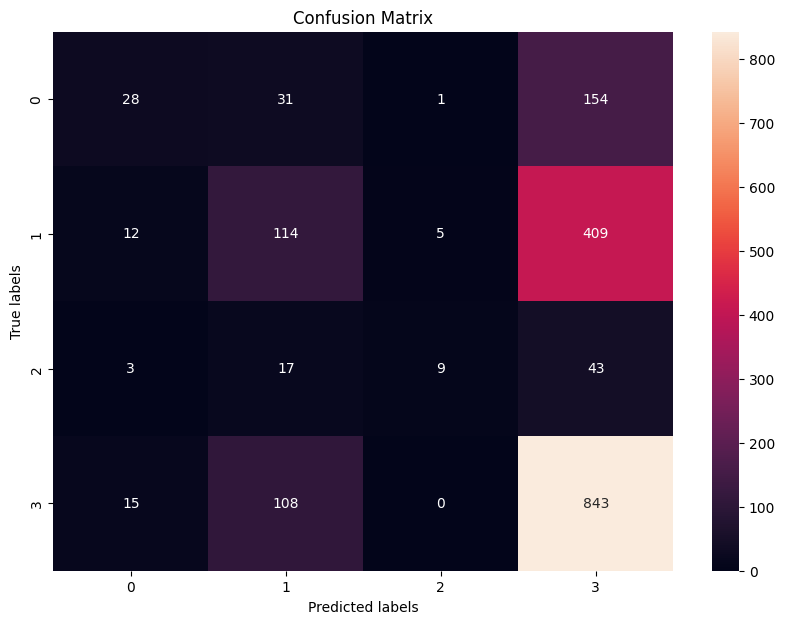

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate and print the accuracy
accuracy = accuracy_score(Y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(Y_test, predictions))

# Generate and visualize the confusion matrix
conf_matrix = confusion_matrix(Y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, you can visualize the confusion matrix using seaborn or matplotlib for better interpretation
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
predictions

array([3, 3, 3, ..., 3, 3, 3])

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_level = mean_squared_error(Y_test.iloc[:, 0], predictions)
rmse_level = np.sqrt(mse_level)
mae_level = mean_absolute_error(Y_test.iloc[:, 0], predictions)

print("Crime Level - MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(mse_level, rmse_level, mae_level))

Crime Level - MSE: 2.0720, RMSE: 1.4394, MAE: 0.9247
